In [1]:
import os
import torch
import random
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.manifold import TSNE
from torchvision import transforms, models
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from sklearn.neighbors import KNeighborsClassifier

In [2]:
dataset_path = "Prostate Cancer"
classes = ['nongland', 'tumor', 'gland']

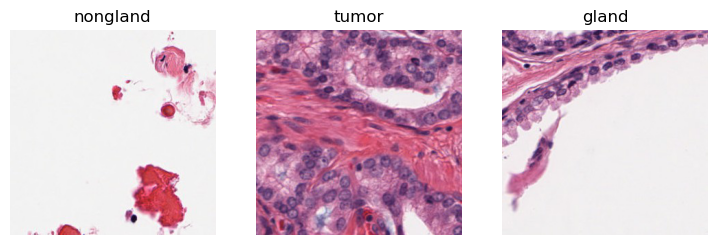

In [3]:
fig, axs = plt.subplots(1, 3, figsize=(9, 5))
for i, class_name in enumerate(classes):
    class_path = os.path.join(dataset_path, class_name)
    random_image_path = random.choice(os.listdir(class_path))
    random_image = mpimg.imread(os.path.join(class_path, random_image_path), random_image_path)
    axs[i].imshow(random_image)
    axs[i].set_title(class_name)
    axs[i].axis('off')

In [4]:
device = torch.device('cuda')
model = models.vgg11(weights="DEFAULT").to(device)

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

dataset = ImageFolder(dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

In [6]:
all_features = []
all_labels = []
with torch.no_grad():
    for images, labels in dataloader:
        outputs = model.features(images.to('cuda'))
        outputs = model.avgpool(outputs)
        outputs = torch.flatten(outputs, 1)
        all_features.append(outputs)
        all_labels.append(labels)

In [7]:
all_features = torch.cat(all_features, dim=0).cpu().numpy()
all_labels = torch.cat(all_labels, dim=0).cpu().numpy()

In [8]:
tsne = TSNE(n_components=2, random_state=42)
tsne_embedded_features = tsne.fit_transform(all_features)

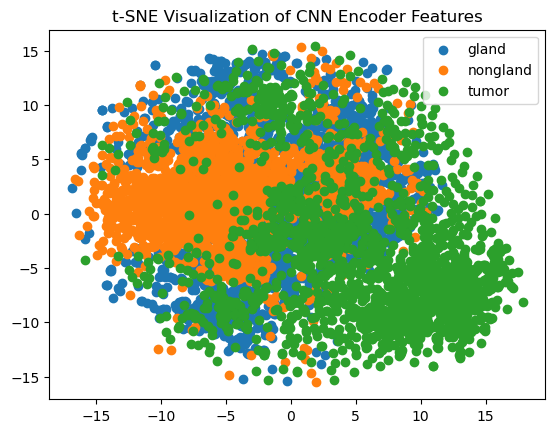

In [9]:
plt.figure()
for i, label in enumerate(dataset.classes):
    plt.scatter(tsne_embedded_features[all_labels == i, 0], tsne_embedded_features[all_labels == i, 1], label=f'{label}')

plt.title('t-SNE Visualization of CNN Encoder Features')
plt.legend()
plt.show()

In [10]:
X_tsne = tsne_embedded_features
y = all_labels
X_train, X_test, y_train, y_test = train_test_split(X_tsne, y, test_size=0.2, random_state=42)

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)
svm = SVC()
svm.fit(X_train_scaled, y_train)
knn_predictions = knn.predict(X_test_scaled)
svm_predictions = svm.predict(X_test_scaled)

In [13]:
# Metrics for k-nearest neighbors
confusion_matrix_knn = confusion_matrix(y_test, knn_predictions)
accuracy_knn = accuracy_score(y_test, knn_predictions)
precision_knn = precision_score(y_test, knn_predictions, average='weighted')
recall_knn = recall_score(y_test, knn_predictions, average='weighted')
f1_score_knn = f1_score(y_test, knn_predictions, average='weighted')

In [14]:
# Metrics for Support Vector Machine
confusion_matrix_svm = confusion_matrix(y_test, svm_predictions)
accuracy_svm = accuracy_score(y_test, svm_predictions)
precision_svm = precision_score(y_test, svm_predictions, average='weighted')
recall_svm = recall_score(y_test, svm_predictions, average='weighted')
f1_score_svm = f1_score(y_test, svm_predictions, average='weighted')

In [15]:
print("K-Nearest Neighbors Metrics:")
print("Confusion Matrix:\n", confusion_matrix_knn/confusion_matrix_knn.sum(axis=1))
print("Accuracy:", accuracy_knn)
print("Precision:", precision_knn)
print("Recall:", recall_knn)
print("F1 Score:", f1_score_knn)

print("\nSupport Vector Machine Metrics:")
print("Confusion Matrix:\n", confusion_matrix_svm/confusion_matrix_svm.sum(axis=1))
print("Accuracy:", accuracy_svm)
print("Precision:", precision_svm)
print("Recall:", recall_svm)
print("F1 Score:", f1_score_svm)

K-Nearest Neighbors Metrics:
Confusion Matrix:
 [[0.70480549 0.20789474 0.1305483 ]
 [0.13043478 0.81315789 0.03655352]
 [0.19221968 0.05       0.7310705 ]]
Accuracy: 0.7475
Precision: 0.7500114905937924
Recall: 0.7475
F1 Score: 0.7477067155473128

Support Vector Machine Metrics:
Confusion Matrix:
 [[0.7208238  0.26052632 0.06005222]
 [0.19908467 0.75526316 0.0156658 ]
 [0.30663616 0.04210526 0.60835509]]
Accuracy: 0.6958333333333333
Precision: 0.7239328603483853
Recall: 0.6958333333333333
F1 Score: 0.6988212908409964
